In [1]:
# These libraries are available in the Python 3 kernel
import pandas as pd
import numpy as np

# These libraries are not available in the Python 3 kernel but are in py-gordon_2_0_0
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sklearn as skl

# Simulations

## Variables (i.e. our outputs), dates available, ensemble member names

In [2]:
variable_names = {
        "dust" : "atmosphere_optical_thickness_due_to_dust_ambient_aerosol",
        "soluble_aitken_mode" : "atmosphere_optical_thickness_due_to_soluble_aitken_mode_ambient_aerosol",
        "soluble_accumulation_mode" : "atmosphere_optical_thickness_due_to_soluble_accumulation_mode_ambient_aerosol",
        "soluble_coarse_mode" : "atmosphere_optical_thickness_due_to_soluble_coarse_mode_ambient_aerosol",
        "insoluble_aitken_mode" : "atmosphere_optical_thickness_due_to_insoluble_aitken_mode_ambient_aerosol",
        "insoluble_accumulation_mode" : "atmosphere_optical_thickness_due_to_insoluble_accumulation_mode_ambient_aerosol",
        "insoluble_coarse_mode" : "atmosphere_optical_thickness_due_to_insoluble_coarse_mode_ambient_aerosol"
}

dates = ["0" + str(int("0801") + k*int("0001"))
         for k in range(0, 31)] + ["0" + str(int("0901") + k*int("0001"))
                                   for k in range(0, 30)]

times = ['3A', '6A', '9A', '12P', '3P', '6P', '9P', '12A']

ensemble = ["0"*(3-len(str(int("000") + k*int("001")))) + str(int("000") + k*int("001")) for k in range(0, 220)]

# Obtain a comma-separated table of simulation ensemble members' parameter combinations
csv_table_metric = c3.SimulationModelParameters.fetch().objs.toJson()

# Save this table instead as a pandas dataframe (221 ensemble members x 64 parameters)
dfparams = pd.DataFrame(csv_table_metric)
dfparams["member"] = dfparams.id.str.split('_', 3, expand=True)[3].apply(lambda x: x.zfill(3))
dfparams_of_interest = dfparams.iloc[:, 5:65]

## Open sample

In [3]:
def open_sat_sim(date = "0826", member = "000"):
    """
    The variable atmosphere optical depth (AOD) as found in the simulated satellite data sets are indexed by the pseudo 
    level (the wavelength for which the AOD was calculated), time (which 3X-hour mark in the day when the simulated data 
    are meant to occur), latitude, and longitude.
    
    Parameters

    date : Day of 2017 of form "mmdd"
    member : Ensemble member, from 000-220

    Value

    netCDF data frame
    """

    file_name = "azure://monthly-mean-simulations/bs714a.pb2017" + date + ".pp_" + member + ".nc"

    return(c3.NetCDFUtil.openFile(file_name))


def open_sat_obs(url):
    return(c3.NetCDFUtil.openFile(url))

## Obtain data frame from sample

In [4]:
def flatten_variable(df, name):
    """
    Helper function for 'select_sim_data'

    Parameters

    df : netCDF data frame
    name : string, the name of a variable 
    
    Value
    
    list, a 1-d vector of elements in the chosen array
    """

    var = df[name][:][2, :, :, :]

    return(np.array(var).flatten())


def select_sim_data(df, member = "000"):
    """
    Unpack the netCDF file as a Pandas dataframe

    Parameters

    df : netCDF data frame
    times : list of strings, the time periods at which the simulated data are meant to occur

    Value

    Pandas DataFrame with columns the variables in df
    """

    # First produce a table of all time-latitude-longitude combinations (in a carefully managed order!) Note: We rotate
    # longitude values by 180 degrees so that they fall between -180 and +180, just as the data are plotted
    lat = df["latitude"][:]
    lon = [x*(x < 180) + (x - 360)*(x >= 180) for x in df["longitude"][:]]

    data = pd.DataFrame()
    data["time"] = [t for t in times for n in range(0, len(lat)*len(lon))]
    data["latitude"] = [l for l in lat for n in range(0, len(lon))]*len(times)
    data["longitude"] = [l for l in lon]*len(times)*len(lat)
    data["member"] = member

    # Enter each aerosol into the data frame by flattening the 4-d arrays from df
    for var in variable_names.items():
        data[var[0]] = flatten_variable(df, var[1])

    data = pd.merge(data,
                    dfparams_of_interest,
                    on="member",
                    how="inner")

    return(data)

### Example data frame

In [139]:
print(select_sim_data(open_sat_sim(date = "0826", member = "000")))

       time  latitude  longitude member      dust  soluble_aitken_mode  \
0        3A   -89.375     0.9375    000  0.000631             0.000485   
1        3A   -89.375     2.8125    000  0.000630             0.000482   
2        3A   -89.375     4.6875    000  0.000629             0.000481   
3        3A   -89.375     6.5625    000  0.000628             0.000481   
4        3A   -89.375     8.4375    000  0.000627             0.000481   
...     ...       ...        ...    ...       ...                  ...   
221179  12A    89.375    -8.4375    000  0.000223             0.012908   
221180  12A    89.375    -6.5625    000  0.000222             0.012395   
221181  12A    89.375    -4.6875    000  0.000222             0.012427   
221182  12A    89.375    -2.8125    000  0.000221             0.011805   
221183  12A    89.375    -0.9375    000  0.000221             0.011811   

        soluble_accumulation_mode  soluble_coarse_mode  insoluble_aitken_mode  \
0                        0.016

## Compile all data frames

In [140]:
def compile_output(ensem_membs=["000"], region=[-180, 180, -90, 90], one_day=1, date='0826', one_time=1, time='9A'):
    """
    Parameters

    num_ensem_mems : integer
        For speed, sometimes only a subset of the ensemble are desired for compiling
    region : list of integers
        The region of the globe whose data is desired
    one_day : integer
        If zero, compile all days available. Else, only obtain data from the given day.
    day : string
        Of the form 'mmdd', the day for which data is desired.
    time : string
        Of the form 'HA' or 'HP', where 'H' is the hour (a multiple of 3) and 'A' or 'P' designates AM or PM

    Value

    Pandas DataFrame
        All of the data satisfying the request specified by the parameters
    """
    data = pd.DataFrame()

    # Decide which ensemble members to compile
    my_members = ensem_membs

    # Decide which days to compile
    if one_day != 0:
        my_days = [date]
    else:
        my_days = dates

    # Decide which days to compile
    if one_time != 0:
        my_times = [time]
    else:
        my_times = times

    # Loop through all of my_members, my_days and append them to the data
    for memb in my_members:
        for day in my_days:
            for tm in my_times:
                # Obtain data frame for given member, day, time combo
                dataset = open_sat_sim(date = day, member = memb)
                sample = select_sim_data(dataset)

                # Subset the sample data frame accordingly
                sample = sample[
                    (sample.time == tm) &
                    (sample.longitude >= region[0]) &
                    (sample.longitude <= region[1]) &
                    (sample.latitude >= region[2]) &
                    (sample.latitude <= region[3])
                ]

                sample["member"] = memb
                sample["date"] = day

                data = data.append(sample)

    return(data)

### Example: some ensemble members for 26 August

In [141]:
aug_26_100 = compile_output(ensem_membs=ensemble[0:100], region=[-45, 40, -30, 10])

      time  latitude  longitude member      dust  soluble_aitken_mode  \
64512   9A   -29.375     0.9375    000  0.000575             0.001048   
64513   9A   -29.375     2.8125    000  0.000624             0.001114   
64514   9A   -29.375     4.6875    000  0.000677             0.001022   
64515   9A   -29.375     6.5625    000  0.000725             0.001052   
64516   9A   -29.375     8.4375    000  0.000767             0.001104   
...    ...       ...        ...    ...       ...                  ...   
70651   9A     9.375    -8.4375    099  0.003305             0.005139   
70652   9A     9.375    -6.5625    099  0.007738             0.005091   
70653   9A     9.375    -4.6875    099  0.012976             0.004320   
70654   9A     9.375    -2.8125    099  0.014368             0.004676   
70655   9A     9.375    -0.9375    099  0.010553             0.005034   

       soluble_accumulation_mode  soluble_coarse_mode  insoluble_aitken_mode  \
64512                   0.055618           

### Example: all ensemble members for 26 August

In [143]:
aug_26_220 = compile_output(ensem_membs=ensemble[100:221], region=[-45, 40, -30, 10])

KeyboardInterrupt: 

In [160]:
aug_26 = pd.concat([aug_26_100, aug_26_220],
                   axis=0)

# Plot simulated data

## One output, one ensemble member

In [5]:
def plot_sat_sim(sample, region=[-180, 180, -90, 90], time='9A', output='soluble_accumulation_mode'):
    """
    Plot the aerosol output of choice simulated around within the specified region for the given sample

    Parameters

    sample : Pandas DataFrame
        Obtained from 'select_sim_data'
    region : list of integers
        The box within which a plot is required, written

        [<minimum longitude>, <maximum longitude>, <minimum latitude>, <maximum latitude>]

    time : string
        Time of day from ['3A', '6A', '9A', '12P', '3P', '6P', '9P', '12A']
    output : string
        Name of variable to be the color dimension of plot
    """

    # Define the figure size and shape
    BBox = [max([region[0], sample.longitude.min()]),
            min([region[1], sample.longitude.max()]),
            max([region[2], sample.latitude.min()]),
            min([region[3], sample.latitude.max()])]

    sample = sample[
        (sample.time == time) &
        (sample.longitude >= BBox[0]) &
        (sample.longitude <= BBox[1]) &
        (sample.latitude >= BBox[2]) &
        (sample.latitude <= BBox[3])
    ]
    
    projection = ccrs.PlateCarree(central_longitude=0)
    fig = plt.figure(figsize=(20,20))

    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.coastlines()

    # Produce gridlines, coordinate labels
    ax.set_extent(BBox, ccrs.PlateCarree())
    ax.gridlines(draw_labels=True, crs=projection)
    ax.set_facecolor("lightgrey")

    # Add points along flight path and color for altitude
    scatter = ax.scatter(sample.longitude, sample.latitude, zorder=1, alpha=1,
                         c=sample[output], cmap="YlOrRd", s=10)
    cbar = plt.colorbar(scatter, shrink=0.6)
    cbar.set_label(output)

    plt.show()

### Example

/home/c3/.conda/envs/py-gordon_2_0_0/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


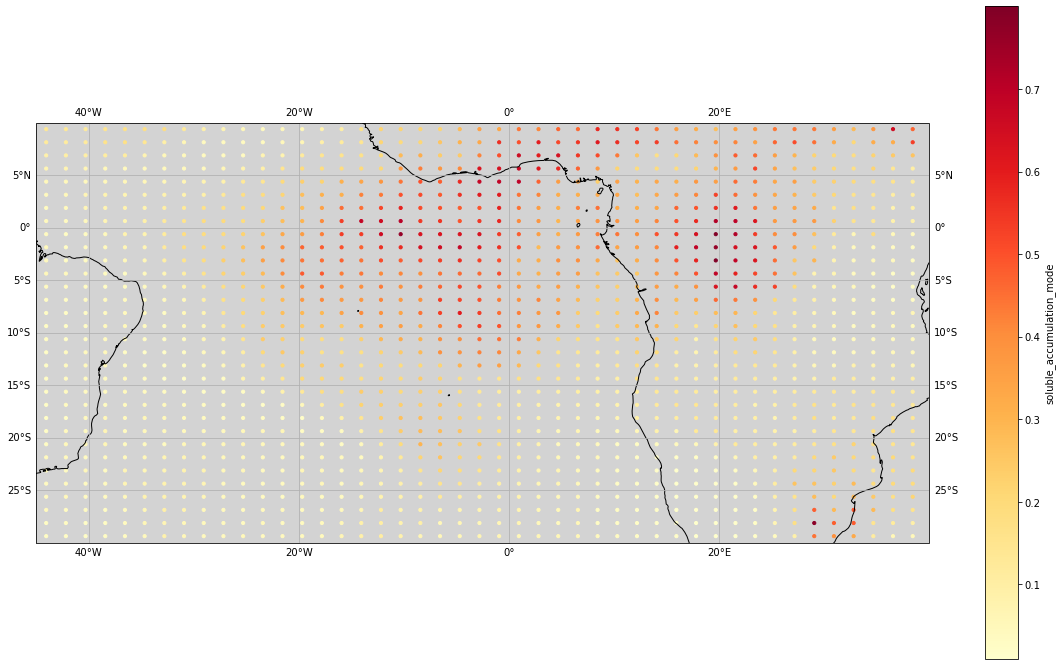

In [6]:
sample = select_sim_data(open_sat_sim())

plot_sat_sim(
    sample,
    region=[-45, 40, -30, 10],
    time='9A',
    output="soluble_accumulation_mode")

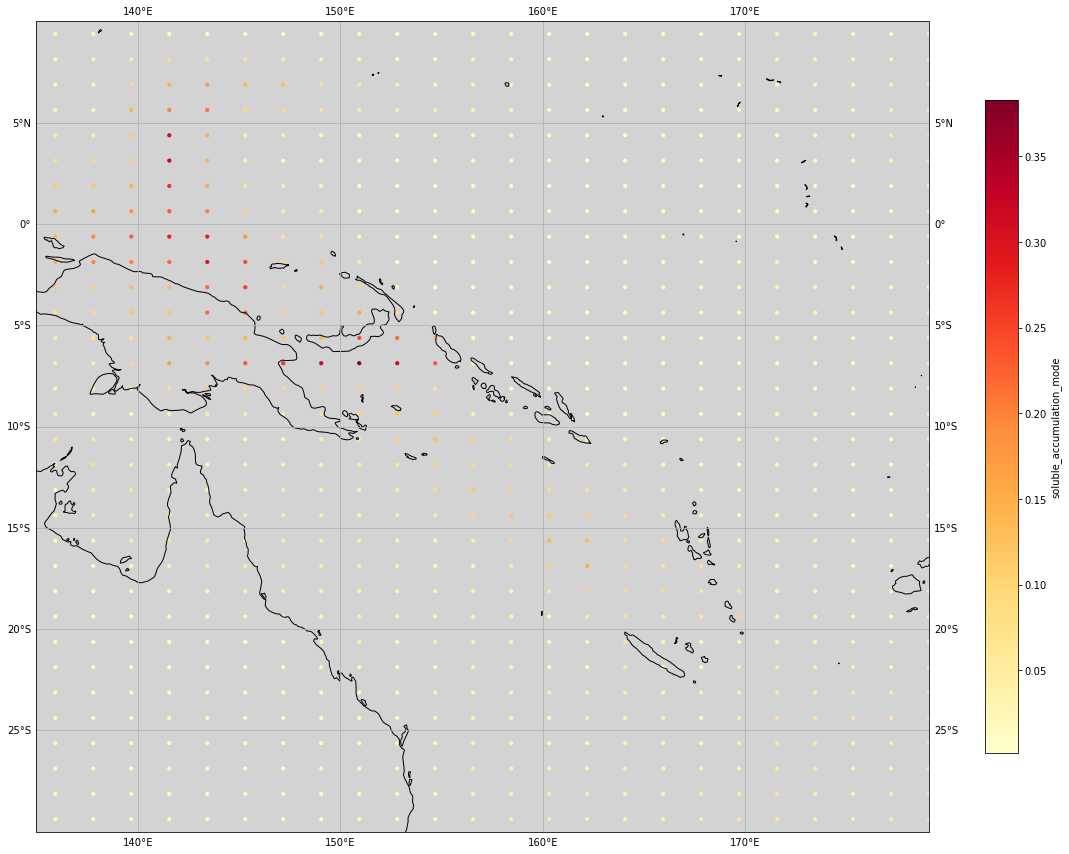

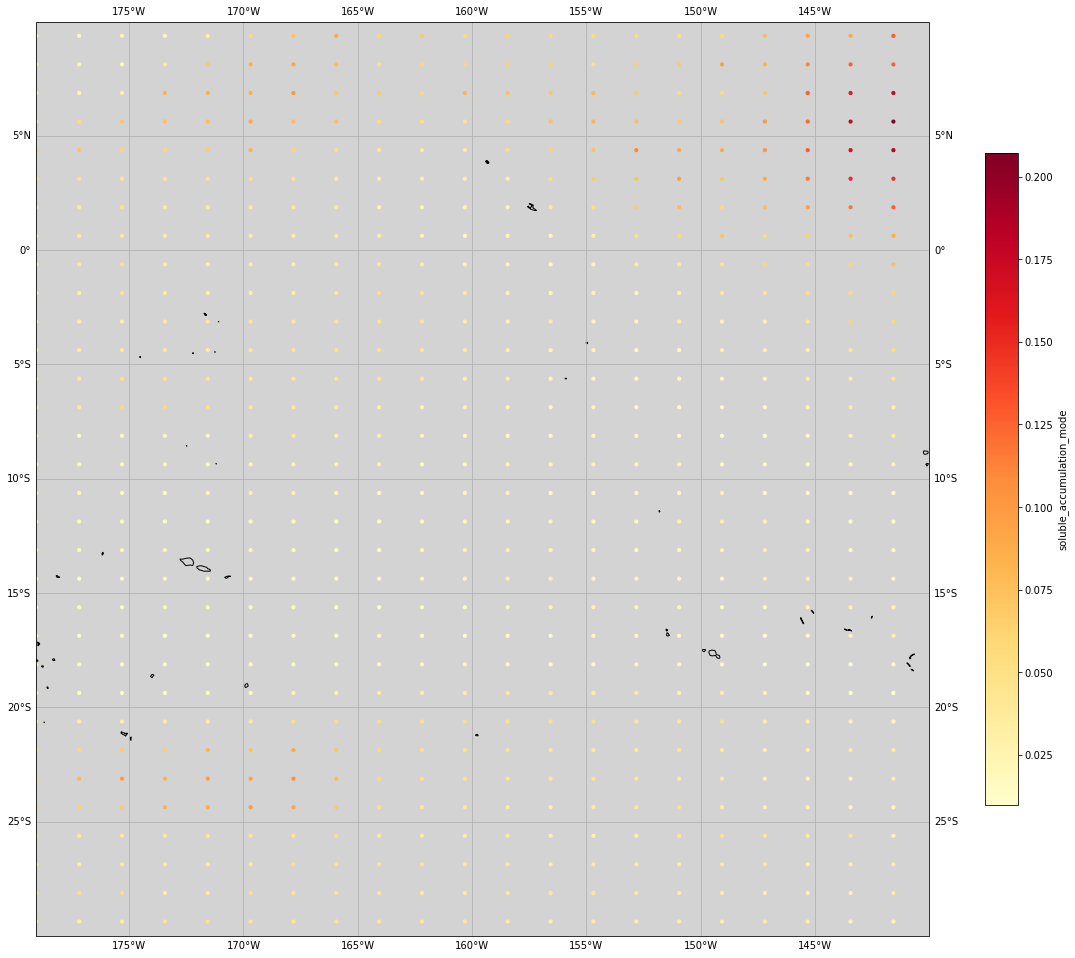

In [11]:
sample = select_sim_data(open_sat_sim())

plot_sat_sim(
    sample,
    region=[-45+180, 40+180, -30, 10],
    time='9A',
    output="soluble_accumulation_mode")

plot_sat_sim(
    sample,
    region=[-45-180, 40-180, -30, 10],
    time='9A',
    output="soluble_accumulation_mode")

## One output, many ensemble members

In [38]:
def quantile_z(sample, q, lat, lon, output='soluble_accumulation_mode'):
    """
    Obtain the qth quantile of the chosen simulated output for a given latitude, longitude pair from a sample of 
    ensemble simulations
    """
    point_sample = sample[(sample.latitude == lat) & (sample.longitude == lon)]
    
    return(np.quantile(point_sample[output], q))


def plot_sat_ensem_range_3d(ensem_data, region=[-45, 40, -30, 10], output='soluble_accumulation_mode'):
    """

    Parameters

    ensem_data : Pandas DataFrame
        Obtained from 'compile_data'
    region : list of integers
        The box within which a plot is required, written

        [<minimum longitude>, <maximum longitude>, <minimum latitude>, <maximum latitude>]

    time : string
        Time of day from ['3A', '6A', '9A', '12P', '3P', '6P', '9P', '12A']
    output : string
        Name of variable to be the color dimension of plot
    """
    sample = ensem_data[
        (ensem_data.longitude >= region[0]) &
        (ensem_data.longitude <= region[1]) &
        (ensem_data.latitude >= region[2]) &
        (ensem_data.latitude <= region[3])
    ]
    
    unique_lats = np.flipud(np.unique(sample.latitude))
    unique_lons = np.unique(sample.longitude)

    x = np.array([unique_lons]*len(unique_lats))
    y = np.array([unique_lats]*len(unique_lons)).T

    BBox = [max([region[0], sample.longitude.min()]),
            min([region[1], sample.longitude.max()]),
            max([region[2], sample.latitude.min()]),
            min([region[3], sample.latitude.max()]),
            sample[output].min(),
            sample[output].max()]

    fig = plt.figure(figsize=[20, 20])
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel(output)

    z50 = np.empty([len(unique_lats), len(unique_lons)])
    z90 = np.empty([len(unique_lats), len(unique_lons)])

    for lat in range(len(unique_lats)):
        for lon in range(len(unique_lons)):
            z50[lat, lon] = quantile_z(sample, 0.5, unique_lats[lat], unique_lons[lon], output)
            z90[lat, lon] = quantile_z(sample, 0.9, unique_lats[lat], unique_lons[lon], output)

    surf = ax.plot_surface(x, y, z50, alpha=0.5, color="blue")
    surf = ax.plot_surface(x, y, z90, alpha=0.5, color="red")
    plt.show()

### Example:

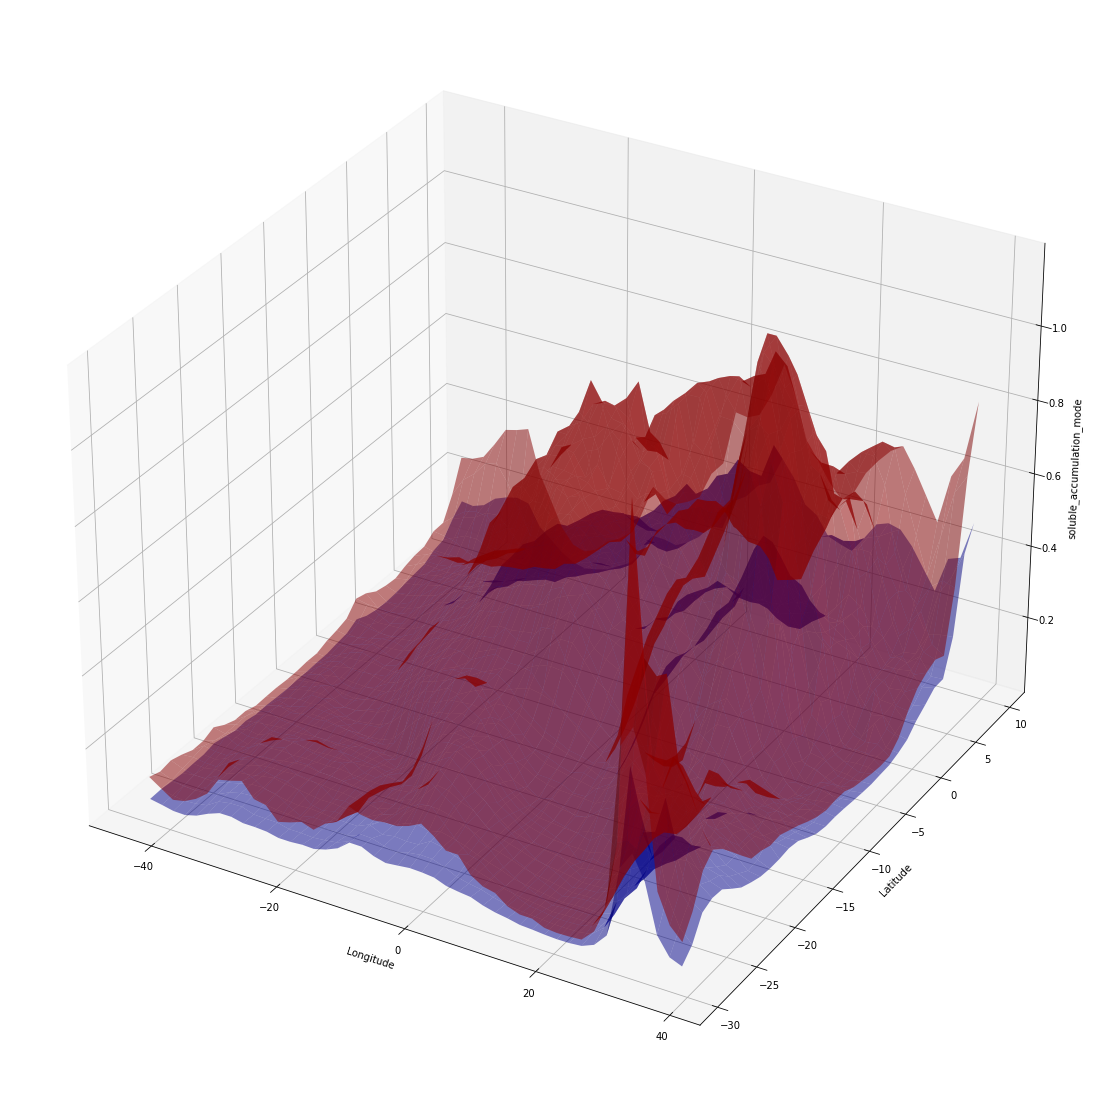

In [45]:
plot_sat_ensem_range_3d(aug_26_100)

# Observations

In [28]:
def select_obs_data(sample):
    """
    Unpack the netCDF file as a Pandas dataframe

    Parameters

    df : netCDF data frame
    times : list of strings, the time periods at which the simulated data are meant to occur

    Value

    Pandas DataFrame with columns the variables in df
    """

    # First produce a table of all time-latitude-longitude combinations (in a carefully managed order!) Note: We rotate
    # longitude values by 180 degrees so that they fall between -180 and +180, just as the data are plotted
    lat = sample["latitude"][:]
    lon = [x*(x < 180) + (x - 360)*(x >= 180) for x in sample["longitude"][:]]

    data = pd.DataFrame()
    # data["time"] = [t for t in times for n in range(0, len(lat)*len(lon))]
    data["latitude"] = [l for l in lat for n in range(0, len(lon))]*len(times)
    data["longitude"] = [l for l in lon]*len(times)*len(lat)

    # Enter each aerosol into the data frame by flattening the 4-d arrays from df
    for var in sample.variables.keys():
        data[var[0]] = flatten_variable(sample, var[1])

    """
    data = pd.merge(data,
                    dfparams_of_interest,
                    on="member",
                    how="inner")
    """

    return(data)

# print(select_obs_data(open_sat_obs(obs_files_list[100].url)))

IndexError: E not found in /

In [14]:
obs_files_list = c3.FileSystem.inst().listFiles("azure://modis-daily-level3/").files
len(obs_files_list)

241

In [17]:
print([obs_files_list[k].url for k in range(241)])

['azure://modis-daily-level3/MOD08_D3.A2017182.061.2017315232249.nc', 'azure://modis-daily-level3/MOD08_D3.A2017183.061.2017315233242.nc', 'azure://modis-daily-level3/MOD08_D3.A2017184.061.2017315232921.nc', 'azure://modis-daily-level3/MOD08_D3.A2017185.061.2017316164218.nc', 'azure://modis-daily-level3/MOD08_D3.A2017186.061.2017316163858.nc', 'azure://modis-daily-level3/MOD08_D3.A2017187.061.2017316175742.nc', 'azure://modis-daily-level3/MOD08_D3.A2017188.061.2017316174814.nc', 'azure://modis-daily-level3/MOD08_D3.A2017189.061.2017316173326.nc', 'azure://modis-daily-level3/MOD08_D3.A2017190.061.2017316182634.nc', 'azure://modis-daily-level3/MOD08_D3.A2017191.061.2017316182738.nc', 'azure://modis-daily-level3/MOD08_D3.A2017192.061.2017316182804.nc', 'azure://modis-daily-level3/MOD08_D3.A2017193.061.2017316191846.nc', 'azure://modis-daily-level3/MOD08_D3.A2017194.061.2017316191608.nc', 'azure://modis-daily-level3/MOD08_D3.A2017195.061.2017316191858.nc', 'azure://modis-daily-level3/MOD08

In [3]:
print(c3.NetCDFUtil.openFile(obs_files_list[0].url).variables.keys())

odict_keys(['AE1_Ocean_JHisto_Intervals', 'AE2_Ocean_JHisto_Intervals', 'AOD_550_Dark_Target_Deep_Blue_Combined_Histogram_Counts', 'AOD_550_Dark_Target_Deep_Blue_Combined_Maximum', 'AOD_550_Dark_Target_Deep_Blue_Combined_Mean', 'AOD_550_Dark_Target_Deep_Blue_Combined_Minimum', 'AOD_550_Dark_Target_Deep_Blue_Combined_Standard_Deviation', 'AOD_Histo_Intervals', 'Aerosol_AE1_Ocean_JHisto_vs_Opt_Depth', 'Aerosol_AE2_Ocean_JHisto_vs_Opt_Depth', 'Aerosol_Avg_Cloud_Distance_Land_Ocean_Maximum', 'Aerosol_Avg_Cloud_Distance_Land_Ocean_Mean', 'Aerosol_Avg_Cloud_Distance_Land_Ocean_Minimum', 'Aerosol_Avg_Cloud_Distance_Land_Ocean_Pixel_Counts', 'Aerosol_Avg_Cloud_Distance_Land_Ocean_Standard_Deviation', 'Aerosol_Number_Pixels_Used_Land_Histogram_Counts', 'Aerosol_Number_Pixels_Used_Land_Maximum', 'Aerosol_Number_Pixels_Used_Land_Mean', 'Aerosol_Number_Pixels_Used_Land_Minimum', 'Aerosol_Number_Pixels_Used_Land_QA_Mean', 'Aerosol_Number_Pixels_Used_Land_QA_Standard_Deviation', 'Aerosol_Number_Pixe

In [4]:
sample = c3.NetCDFUtil.openFile(obs_files_list[0].url)
sample["AOD_550_Dark_Target_Deep_Blue_Combined_Histogram_Counts"][:].data

array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

       [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

       [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-99

In [9]:
def plot_var(variable_name, our_region=True):
    
    # These libraries are available in the Python 3 kernel
    import pandas as pd
    #import numpy as np

    # These libraries are not available in the Python 3 kernel but are in py-gordon_2_0_0
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    #import sklearn as skl

    for samp in [1, 100]:
        sample = c3.NetCDFUtil.openFile(obs_files_list[samp].url)

        lat = sample["latitude"][:].data
        lon = sample["longitude"][:].data

        data = pd.DataFrame()
        data["latitude"] = [l for l in lat for n in range(0, len(lon))]
        data["longitude"] = [l for l in lon]*len(lat)

        response = sample[variable_name][:].data

        data["response"] = response.flatten()

        data["response"][data["response"] < 0] = 0

        if our_region==True:
            BBox = [-40, 40, -30, 10]
        else:
            BBox = [-180, 180, -90, 90]

        projection = ccrs.PlateCarree(central_longitude=0)
        fig = plt.figure(figsize=[16, 12])

        # Draw island
        ax = fig.add_subplot(1, 1, 1, projection=projection)
        ax.coastlines()

        # Produce gridlines, coordinate labels
        ax.set_extent(BBox, ccrs.PlateCarree())
        ax.gridlines(draw_labels=True, crs=projection)

        # Add points along flight path and color for altitude
        scatter = ax.scatter(data.longitude, data.latitude, zorder=1, alpha=1,
                             c=data.response, cmap="plasma", s=10)
        cbar = plt.colorbar(scatter, shrink=0.6)
        cbar.set_label(variable_name)

        plt.show()


/home/c3/.conda/envs/py-gordon_2_0_0/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/c3/.conda/envs/py-gordon_2_0_0/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


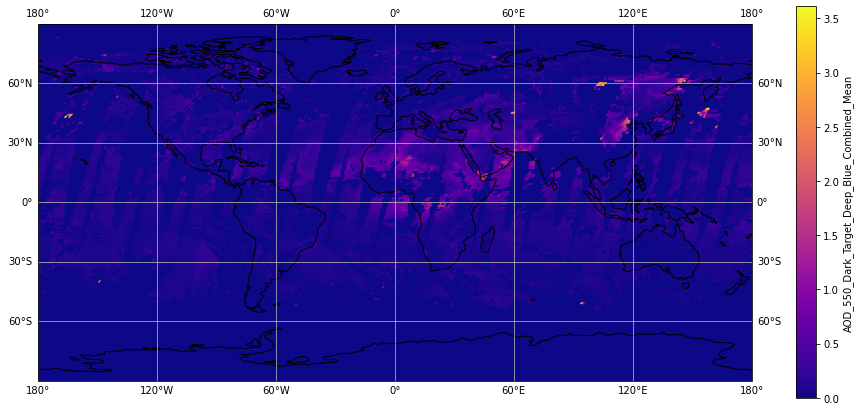

/home/c3/.conda/envs/py-gordon_2_0_0/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


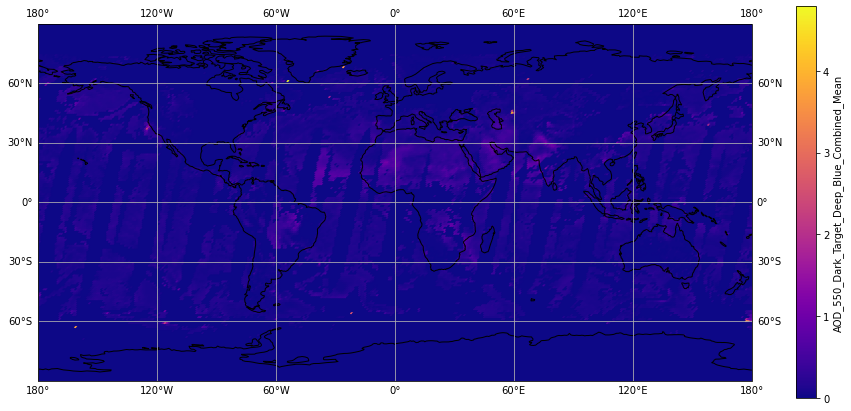

In [10]:
plot_var('AOD_550_Dark_Target_Deep_Blue_Combined_Mean', False)

/home/c3/.conda/envs/py-gordon_2_0_0/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


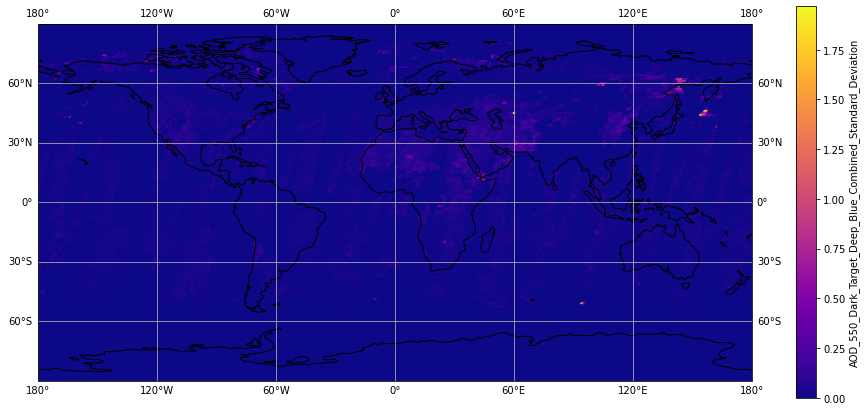

/home/c3/.conda/envs/py-gordon_2_0_0/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


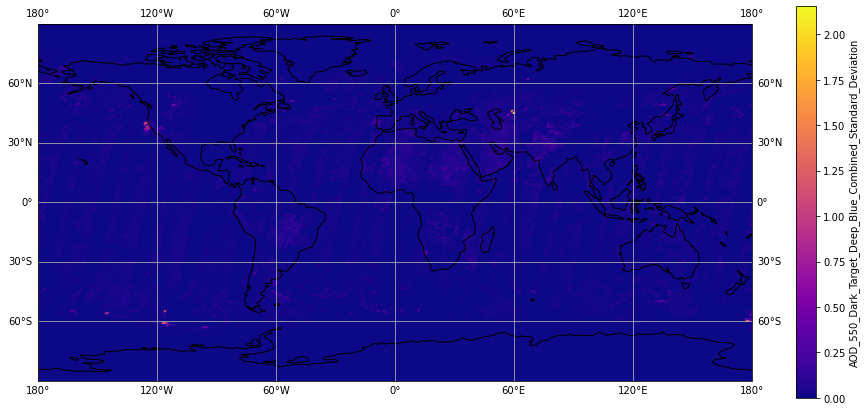

In [11]:
plot_var('AOD_550_Dark_Target_Deep_Blue_Combined_Standard_Deviation', False)

/home/c3/.conda/envs/py-gordon_2_0_0/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


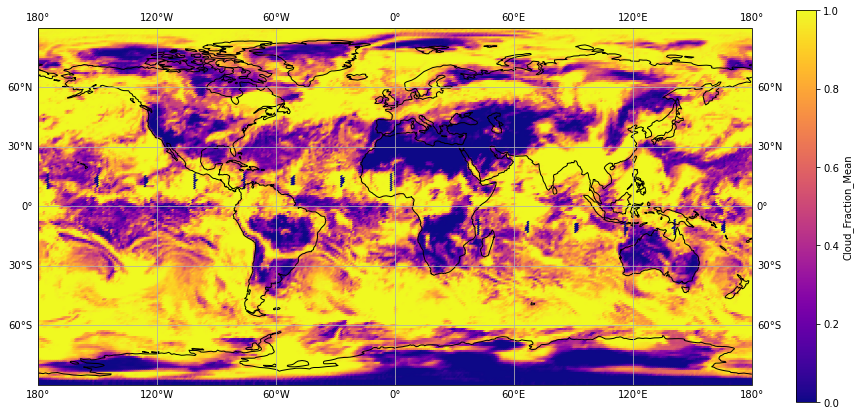

/home/c3/.conda/envs/py-gordon_2_0_0/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


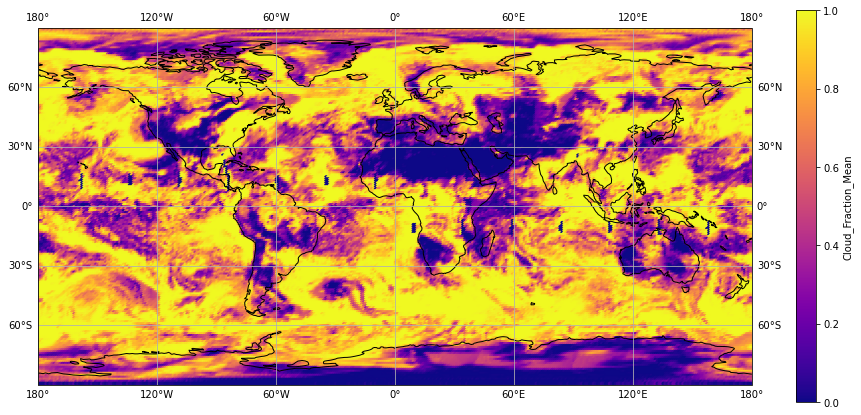

In [12]:
plot_var('Cloud_Fraction_Mean', False)